Tampering ELA approach


🔍 Image: Original.JPEG
📊 Features: mean_error=103.68, max_error=255.00, percent_above_thresh=0.5765, box_area=397137
🚨 Prediction: Tampered


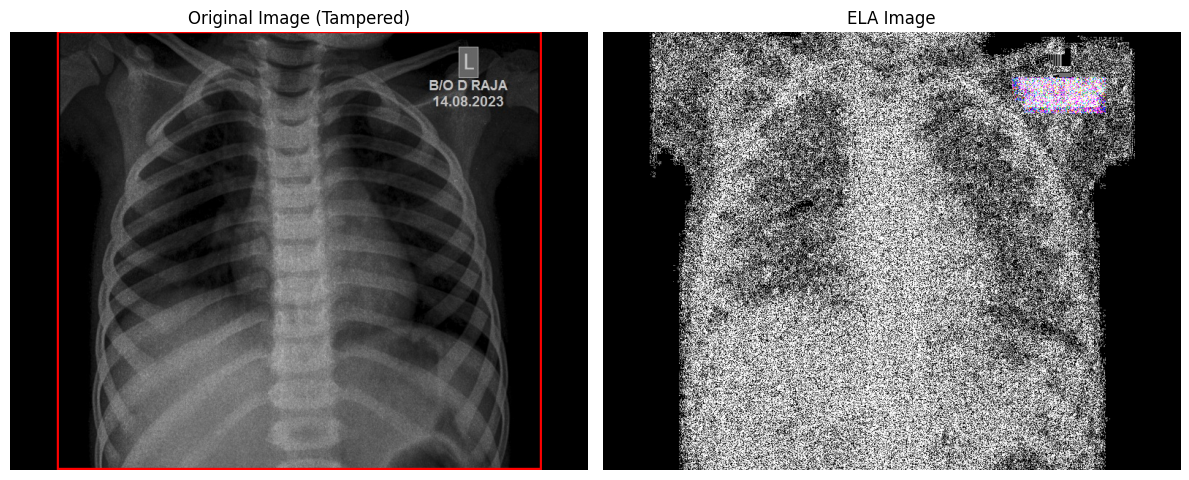


🔍 Image: Original_1.JPEG
📊 Features: mean_error=170.17, max_error=255.00, percent_above_thresh=0.6673, box_area=3879273
✅ Prediction: Untampered


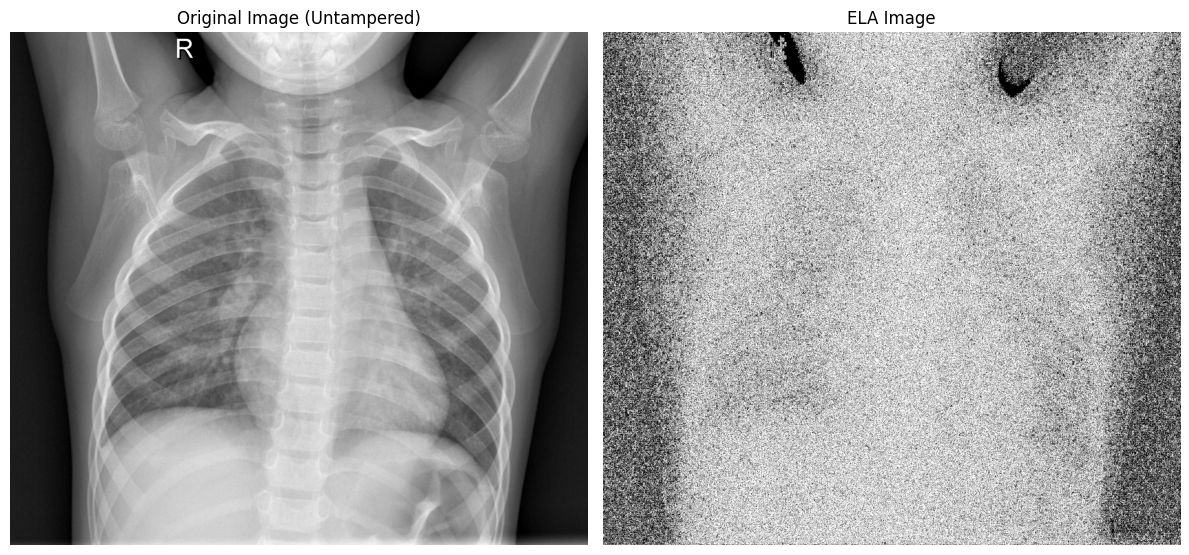


🔍 Image: Tampered.JPEG
📊 Features: mean_error=112.49, max_error=255.00, percent_above_thresh=0.5769, box_area=397137
🚨 Prediction: Tampered


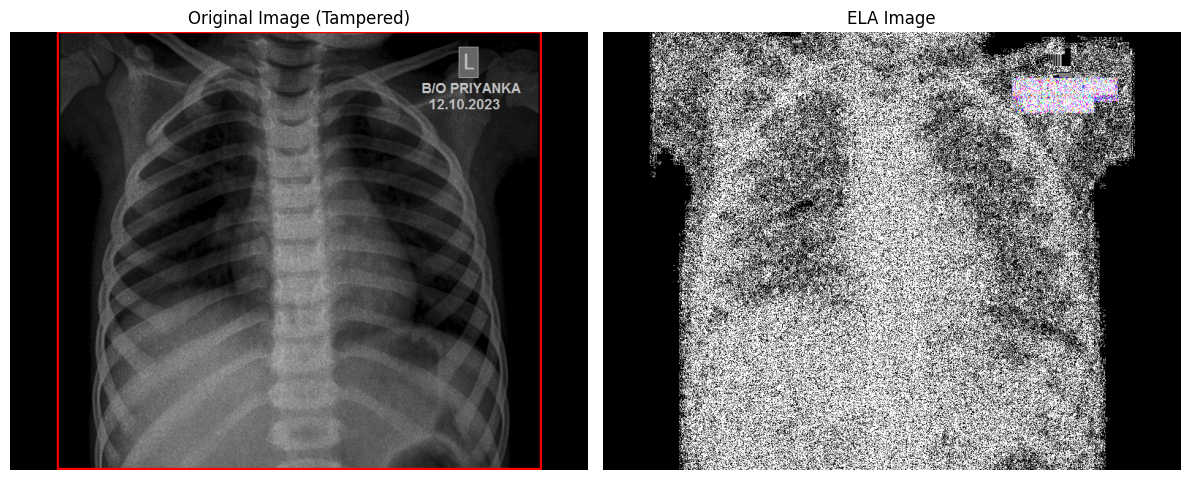


🔍 Image: Tampered_1.jpg
📊 Features: mean_error=116.75, max_error=255.00, percent_above_thresh=0.6547, box_area=3879273
🚨 Prediction: Tampered


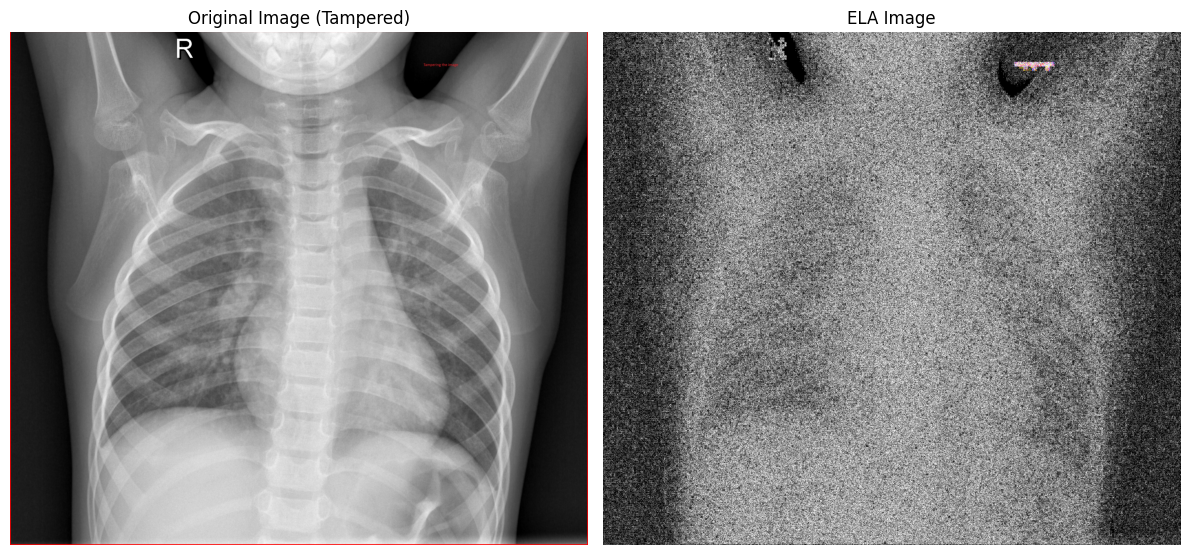


🔍 Image: Tampered_2.jpg
📊 Features: mean_error=91.13, max_error=255.00, percent_above_thresh=0.2561, box_area=3879273
🚨 Prediction: Tampered


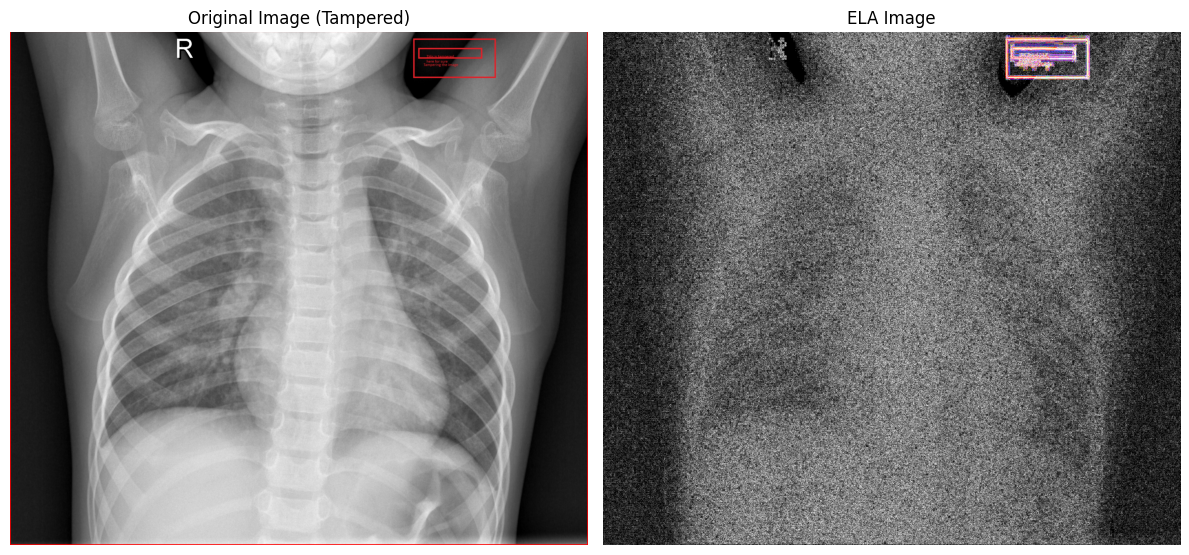


🔍 Image: Tampered_3.jpg
📊 Features: mean_error=128.90, max_error=255.00, percent_above_thresh=0.6031, box_area=3879273
🚨 Prediction: Tampered


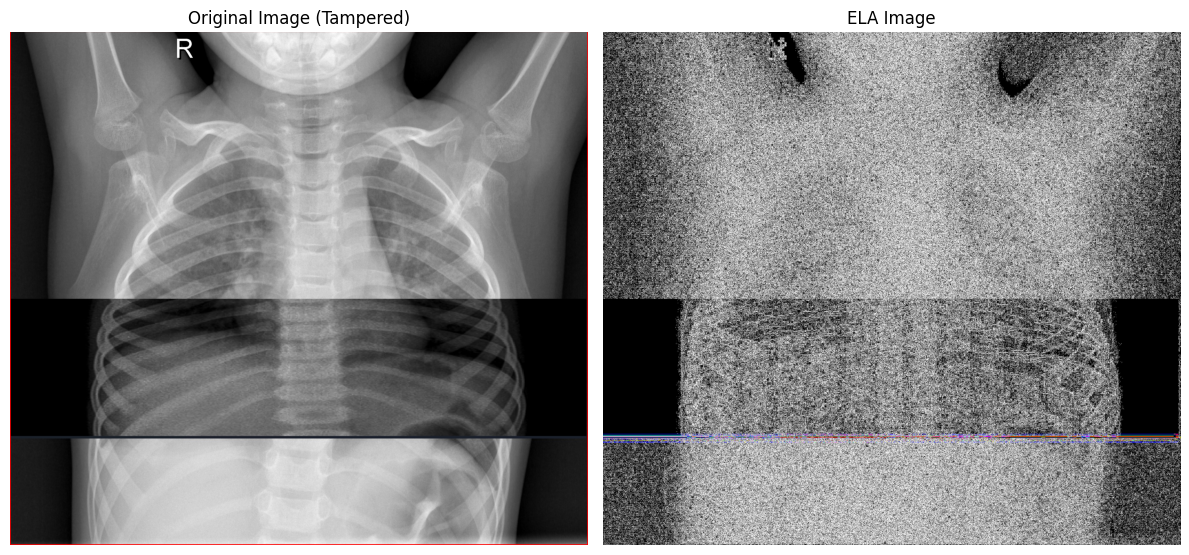

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance, ImageDraw

def extract_ela_features_and_image(image_path, quality=90, scale=15, threshold=100):
    original = Image.open(image_path).convert('RGB')
    temp_path = "temp_ela.jpg"
    original.save(temp_path, 'JPEG', quality=quality)
    compressed = Image.open(temp_path)
    diff = ImageChops.difference(original, compressed)

    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    ela_image = ImageEnhance.Brightness(diff).enhance((255.0 / max_diff) * scale)
    os.remove(temp_path)

    ela_np = np.array(ela_image)
    gray = np.mean(ela_np, axis=2)

    mean_error = np.mean(gray)
    max_error = np.max(gray)
    percent_above_thresh = np.sum(gray > threshold) / gray.size

    mask = gray > threshold
    coords = np.argwhere(mask)
    box_area = 0
    box_coords = None
    if coords.any():
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        box_area = (y1 - y0) * (x1 - x0)
        box_coords = (x0, y0, x1, y1)

    return {
        'mean_error': mean_error,
        'max_error': max_error,
        'percent_above_thresh': percent_above_thresh,
        'box_area': box_area,
        'ela_image': ela_image,
        'original': original,
        'box_coords': box_coords
    }

def predict_and_visualize(image_path,
                          threshold=100,
                          percent_thresh=0.003,
                          box_area_thresh=200,
                          max_error_thresh=180):
    data = extract_ela_features_and_image(image_path, threshold=threshold)
    original = data['original'].copy()
    ela_image = data['ela_image']
    box_coords = data['box_coords']

    mean_error = data['mean_error']
    max_error = data['max_error']
    percent_above_thresh = data['percent_above_thresh']
    box_area = data['box_area']

    print(f"\n🔍 Image: {os.path.basename(image_path)}")
    print(f"📊 Features: "
          f"mean_error={mean_error:.2f}, "
          f"max_error={max_error:.2f}, "
          f"percent_above_thresh={percent_above_thresh:.4f}, "
          f"box_area={box_area}")

    # ✅ Final rule: skip if image is globally noisy
    if percent_above_thresh > 0.66:
        is_tampered = False
    else:
        is_tampered = (
            max_error > max_error_thresh and
            box_area > box_area_thresh and
            percent_above_thresh > percent_thresh
        )

    result = "Tampered" if is_tampered else "Untampered"
    print(f"{'🚨' if is_tampered else '✅'} Prediction: {result}")

    if is_tampered and box_coords:
        draw = ImageDraw.Draw(original)
        draw.rectangle(box_coords, outline="red", width=3)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original)
    axes[0].set_title(f"Original Image ({result})")
    axes[0].axis("off")

    axes[1].imshow(ela_image)
    axes[1].set_title("ELA Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# === Run It ===
if __name__ == "__main__":
    image_folder = r"C:\Users\Dell\Desktop\Python Scripts\hmis_project\Practice_Codes\Tamper input"
    image_files = [
        "Original.JPEG",
        "Original_1.JPEG",
        "Tampered.JPEG",
        "Tampered_1.jpg",
        "Tampered_2.jpg",
        "Tampered_3.jpg"
    ]

    for fname in image_files:
        fpath = os.path.join(image_folder, fname)
        predict_and_visualize(fpath)
